In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

'''
Plot exetent/area from observations and models (past and future)
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt, mpld3
from collections import OrderedDict
import itertools
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')


from esio import EsioData as ed
from esio import ice_plot
from esio import metrics

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  F

In [2]:
# Plotting Info
runType = 'forecast'
variables = ['sic'] #, 'hi'
metric1 = 'extent'

In [3]:
# Initialization times to plot
cd = datetime.datetime.now()
cd = datetime.datetime(cd.year, cd.month, cd.day) # Assumes hours 00, min 00
SD = cd - datetime.timedelta(days=90)
# SD = cd - datetime.timedelta(days=4*365)

# ED = cd + datetime.timedelta(days=365)

In [4]:
# Info about models runs
# icePredicted = {'gfdlsipn':True, 'piomas':True, 'yopp':True, 'bom':False, 'cma':True, 'ecmwf':True, 
#               'hcmr':False, 'isaccnr':False, 'jma':False, 'metreofr':True, 'ukmo':True, 'eccc':False, 
#               'kma':True, 'ncep':True, 'ukmetofficesipn':True, 'ecmwfsipn':True}
# biasCorrected = 

In [5]:
#############################################################
# Load in Data
#############################################################
E = ed.EsioData.load()

In [6]:
# Load obs
import timeit
start_time = timeit.default_timer()
ds_obs = xr.open_mfdataset(E.obs['NSIDC_0081']['sipn_nc']+'_yearly/*.nc', concat_dim='time')#,
print(timeit.default_timer() - start_time)

0.136786843650043


In [7]:
# Load in regional data
# Note minor -0.000004 degree differences in latitude
ds_region = xr.open_dataset(os.path.join(E.grid_dir, 'sio_2016_mask_Update.nc'))

In [8]:
cdate = datetime.datetime.now()


# Plot Raw extents and only models that predict sea ice

Sea of Okhotsk
dampedAnomalyTrend
1.3164778929203749  seconds.
gfdlsipn
0.31684620678424835  seconds.
piomas
yopp
2.0361347319558263  seconds.
ukmetofficesipn
16.521243725903332  seconds.
ecmwfsipn
4.318781808018684  seconds.
ecmwf
0.2633334011770785  seconds.
metreofr
0.08466580463573337  seconds.
ukmo
0.8154125092551112  seconds.
kma
0.8398105632513762  seconds.
ncep
0.7116991328075528  seconds.
usnavysipn
0.003032062202692032  seconds.
usnavyncep
0.7794847581535578  seconds.
rasmesrl
2.123238107189536  seconds.
noaasipn
0.03831019112840295  seconds.
noaasipn_ext
usnavygofs
5.327545043081045  seconds.
modcansipns_3
0.021459550131112337  seconds.
modcansipns_4
0.02047407627105713  seconds.
uclsipn
0.017488042823970318  seconds.
szapirosipn
0.010512247681617737  seconds.
awispin
0.019392387941479683  seconds.
nicosipn
0.007927673868834972  seconds.
MME
MME_NEW
Plotting observations


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


Bering
dampedAnomalyTrend
1.2739909440279007  seconds.
gfdlsipn
0.29915350303053856  seconds.
piomas
yopp
2.2672709971666336  seconds.
ukmetofficesipn
14.911115413066  seconds.
ecmwfsipn
4.727635158225894  seconds.
ecmwf
0.21911691408604383  seconds.
metreofr
0.0787499938160181  seconds.
ukmo
0.8170206053182483  seconds.
kma
0.8918688111007214  seconds.
ncep
0.6354740159586072  seconds.
usnavysipn
0.0032875770702958107  seconds.
usnavyncep
1.000413960777223  seconds.
rasmesrl
2.3971745311282575  seconds.
noaasipn
0.02883580792695284  seconds.
noaasipn_ext
usnavygofs
4.889159772079438  seconds.
modcansipns_3
0.02118132682517171  seconds.
modcansipns_4
0.02095012878999114  seconds.
uclsipn
0.01777431322261691  seconds.
szapirosipn
0.010530658066272736  seconds.
awispin
0.019625375978648663  seconds.
nicosipn
0.007266523316502571  seconds.
MME
MME_NEW
Plotting observations


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


Hudson Bay
dampedAnomalyTrend
1.2570386179722846  seconds.
gfdlsipn
0.30377465626224875  seconds.
piomas
yopp
2.4406935749575496  seconds.
ukmetofficesipn
14.989366830326617  seconds.
ecmwfsipn
4.284857858903706  seconds.
ecmwf
0.2497307639569044  seconds.
metreofr
0.10244639404118061  seconds.
ukmo
0.7364547359757125  seconds.
kma
0.7339194300584495  seconds.
ncep
0.7803266388364136  seconds.
usnavysipn
0.003086550161242485  seconds.
usnavyncep
0.7268421859480441  seconds.
rasmesrl
2.1125612440519035  seconds.
noaasipn
0.02886863797903061  seconds.
noaasipn_ext
usnavygofs
5.142201817594469  seconds.
modcansipns_3
0.020843734964728355  seconds.
modcansipns_4
0.02053268114104867  seconds.
uclsipn
0.01759331114590168  seconds.
szapirosipn
0.010479959193617105  seconds.
awispin
0.019284735899418592  seconds.
nicosipn
0.007621557917445898  seconds.
MME
MME_NEW
Plotting observations


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


St John
dampedAnomalyTrend
1.183472990989685  seconds.
gfdlsipn
0.24999640882015228  seconds.
piomas
yopp
1.781390876043588  seconds.
ukmetofficesipn
14.854384254198521  seconds.
ecmwfsipn
4.394206510391086  seconds.
ecmwf
0.19634804083034396  seconds.
metreofr
0.06935597723349929  seconds.
ukmo
0.6438949489966035  seconds.
kma
0.6558208111673594  seconds.
ncep
0.6084638517349958  seconds.
usnavysipn
0.004086918663233519  seconds.
usnavyncep
0.6344397440552711  seconds.
rasmesrl
2.0280384910292923  seconds.
noaasipn
0.03993572108447552  seconds.
noaasipn_ext
usnavygofs
5.208357613068074  seconds.
modcansipns_3
0.021053606178611517  seconds.
modcansipns_4
0.02104778029024601  seconds.
uclsipn
0.01753580290824175  seconds.
szapirosipn
0.011049990076571703  seconds.
awispin
0.019136644434183836  seconds.
nicosipn
0.006948713678866625  seconds.
MME
MME_NEW
Plotting observations


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


Baffin Bay
dampedAnomalyTrend
1.3009761949069798  seconds.
gfdlsipn
0.3444008999504149  seconds.
piomas
yopp
2.255353300832212  seconds.
ukmetofficesipn
14.991629722993821  seconds.
ecmwfsipn
4.514708075206727  seconds.
ecmwf
0.286993894726038  seconds.
metreofr
0.10919041931629181  seconds.
ukmo
0.7290479191578925  seconds.
kma
0.8724564099684358  seconds.
ncep
0.7484240178018808  seconds.
usnavysipn
0.0030883043073117733  seconds.
usnavyncep
0.7845269539393485  seconds.
rasmesrl
2.637589829042554  seconds.
noaasipn
0.03005855903029442  seconds.
noaasipn_ext
usnavygofs
4.958876125980169  seconds.
modcansipns_3
0.02445002691820264  seconds.
modcansipns_4
0.020769815891981125  seconds.
uclsipn
0.017879446037113667  seconds.
szapirosipn
0.010567787103354931  seconds.
awispin
0.019530802965164185  seconds.
nicosipn
0.008526179939508438  seconds.
MME
MME_NEW
Plotting observations


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


East Greenland Sea
dampedAnomalyTrend
1.2155141439288855  seconds.
gfdlsipn
0.2839331729337573  seconds.
piomas
yopp
2.2531270533800125  seconds.
ukmetofficesipn
15.153903718106449  seconds.
ecmwfsipn
4.469673252198845  seconds.
ecmwf
0.2919797538779676  seconds.
metreofr
0.11281717102974653  seconds.
ukmo
0.8427865700796247  seconds.
kma
0.9376437338069081  seconds.
ncep
0.8904591258615255  seconds.
usnavysipn
0.0038764430209994316  seconds.
usnavyncep
0.8246322772465646  seconds.
rasmesrl
2.65212837792933  seconds.
noaasipn
0.02840822096914053  seconds.
noaasipn_ext
usnavygofs
5.1886661648750305  seconds.
modcansipns_3
0.02047293819487095  seconds.
modcansipns_4
0.021025497931987047  seconds.
uclsipn
0.017826823983341455  seconds.
szapirosipn
0.010495658963918686  seconds.
awispin
0.02022096887230873  seconds.
nicosipn
0.007048202212899923  seconds.
MME
MME_NEW
Plotting observations


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


Barents Sea
dampedAnomalyTrend
1.2004873207770288  seconds.
gfdlsipn
0.29309949604794383  seconds.
piomas
yopp
1.9446757580153644  seconds.
ukmetofficesipn
14.882548263762146  seconds.
ecmwfsipn
4.618827871978283  seconds.
ecmwf
0.3013495337218046  seconds.
metreofr
0.10974916024133563  seconds.
ukmo
0.8984441231004894  seconds.
kma
0.9985277010127902  seconds.
ncep
0.9584405431523919  seconds.
usnavysipn
0.00323078827932477  seconds.
usnavyncep
1.2167346230708063  seconds.
rasmesrl
2.2304682140238583  seconds.
noaasipn
0.029082611203193665  seconds.
noaasipn_ext
usnavygofs
5.6632422329857945  seconds.
modcansipns_3
0.021466166246682405  seconds.
modcansipns_4
0.020878958981484175  seconds.
uclsipn
0.017739234026521444  seconds.
szapirosipn
0.010439920239150524  seconds.
awispin
0.019120577722787857  seconds.
nicosipn
0.006959869991987944  seconds.
MME
MME_NEW
Plotting observations


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


Kara Sea
dampedAnomalyTrend
1.2246024617925286  seconds.
gfdlsipn
0.31425425224006176  seconds.
piomas
yopp
1.992253947071731  seconds.
ukmetofficesipn
15.084393464028835  seconds.
ecmwfsipn
4.1161597687751055  seconds.
ecmwf
0.2977042901329696  seconds.
metreofr
0.11932349810376763  seconds.
ukmo
0.8637270000763237  seconds.
kma
0.8195253098383546  seconds.
ncep
0.8005283609963953  seconds.
usnavysipn
0.0029011848382651806  seconds.
usnavyncep
0.7605627388693392  seconds.
rasmesrl
2.241930815856904  seconds.
noaasipn
0.02930212067440152  seconds.
noaasipn_ext
usnavygofs
4.760183238890022  seconds.
modcansipns_3
0.020557614974677563  seconds.
modcansipns_4
0.020808436907827854  seconds.
uclsipn
0.017560872249305248  seconds.
szapirosipn
0.010394231881946325  seconds.
awispin
0.019061352591961622  seconds.
nicosipn
0.006988528184592724  seconds.
MME
MME_NEW
Plotting observations


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


Laptev Sea
dampedAnomalyTrend
1.1286273142322898  seconds.
gfdlsipn
0.2977510318160057  seconds.
piomas
yopp
2.253587191924453  seconds.
ukmetofficesipn
15.804180923849344  seconds.
ecmwfsipn
4.219073256943375  seconds.
ecmwf
0.30515807680785656  seconds.
metreofr
0.12729601981118321  seconds.
ukmo
0.8386055170558393  seconds.
kma
0.7866933369077742  seconds.
ncep
0.7514393404126167  seconds.
usnavysipn
0.00296322675421834  seconds.
usnavyncep
0.7522396096028388  seconds.
rasmesrl
3.2219986696727574  seconds.
noaasipn
0.032007234171032906  seconds.
noaasipn_ext
usnavygofs
5.040915646124631  seconds.
modcansipns_3
0.021275608334690332  seconds.
modcansipns_4
0.02113008825108409  seconds.
uclsipn
0.017927295062690973  seconds.
szapirosipn
0.010699705220758915  seconds.
awispin
0.015504177194088697  seconds.
nicosipn
0.005459846928715706  seconds.
MME
MME_NEW
Plotting observations


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


East Siberian Sea
dampedAnomalyTrend
1.3653903813101351  seconds.
gfdlsipn
0.30047440994530916  seconds.
piomas
yopp
2.4922125549055636  seconds.
ukmetofficesipn
15.163573629688472  seconds.
ecmwfsipn
4.083802242297679  seconds.
ecmwf
0.3127990528009832  seconds.
metreofr
0.1141884489916265  seconds.
ukmo
0.7487998655997217  seconds.
kma
1.55951494211331  seconds.
ncep
0.7597880680114031  seconds.
usnavysipn
0.003385039046406746  seconds.
usnavyncep
0.849060817155987  seconds.
rasmesrl
2.16820326494053  seconds.
noaasipn
0.028959583025425673  seconds.
noaasipn_ext
usnavygofs
5.140511406119913  seconds.
modcansipns_3
0.021622217260301113  seconds.
modcansipns_4
0.02041524788364768  seconds.
uclsipn
0.017584904097020626  seconds.
szapirosipn
0.010502519086003304  seconds.
awispin
0.01906836684793234  seconds.
nicosipn
0.006952058058232069  seconds.
MME
MME_NEW
Plotting observations


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


Chukchi Sea
dampedAnomalyTrend
1.3628157689236104  seconds.
gfdlsipn
0.30595913203433156  seconds.
piomas
yopp
2.371377846226096  seconds.
ukmetofficesipn
14.894303075037897  seconds.
ecmwfsipn
4.308438810985535  seconds.
ecmwf
0.24533692188560963  seconds.
metreofr
0.11074206978082657  seconds.
ukmo
0.8188625159673393  seconds.
kma
0.8308395780622959  seconds.
ncep
0.9457547580823302  seconds.
usnavysipn
0.003037319052964449  seconds.
usnavyncep
0.8318986231461167  seconds.
rasmesrl
2.323414735030383  seconds.
noaasipn
0.03531906893476844  seconds.
noaasipn_ext
usnavygofs
5.830997277982533  seconds.
modcansipns_3
0.021705946885049343  seconds.
modcansipns_4
0.021408547181636095  seconds.
uclsipn
0.01796939317137003  seconds.
szapirosipn
0.010573923122137785  seconds.
awispin
0.01934213424101472  seconds.
nicosipn
0.0070332628674805164  seconds.
MME
MME_NEW
Plotting observations


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


Beaufort Sea
dampedAnomalyTrend
1.2955337492749095  seconds.
gfdlsipn
0.31931276991963387  seconds.
piomas
yopp
2.3273435630835593  seconds.
ukmetofficesipn
14.968926679808646  seconds.
ecmwfsipn
4.402753808069974  seconds.
ecmwf
0.3018405786715448  seconds.
metreofr
0.1373579385690391  seconds.
ukmo
0.9103622357361019  seconds.
kma
0.9226688500493765  seconds.
ncep
0.9376236759126186  seconds.
usnavysipn
0.0029050810262560844  seconds.
usnavyncep
0.8447360778227448  seconds.
rasmesrl
2.2137667750939727  seconds.
noaasipn
0.031603102106601  seconds.
noaasipn_ext
usnavygofs
5.845333589240909  seconds.
modcansipns_3
0.021371941082179546  seconds.
modcansipns_4
0.021371463779360056  seconds.
uclsipn
0.01791667891666293  seconds.
szapirosipn
0.010618314146995544  seconds.
awispin
0.019509037025272846  seconds.
nicosipn
0.0070483931340277195  seconds.
MME
MME_NEW
Plotting observations


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


Canadian Islands
dampedAnomalyTrend
1.2384832189418375  seconds.
gfdlsipn
0.3057883596047759  seconds.
piomas
yopp
2.3453898089937866  seconds.
ukmetofficesipn
15.369435025844723  seconds.
ecmwfsipn
4.52446815231815  seconds.
ecmwf
0.27210026094689965  seconds.
metreofr
0.14024668186903  seconds.
ukmo
0.948645708616823  seconds.
kma
1.0036712079308927  seconds.
ncep
0.9181797821074724  seconds.
usnavysipn
0.0039392076432704926  seconds.
usnavyncep
0.7997691258788109  seconds.
rasmesrl
2.3846666147001088  seconds.
noaasipn
0.028359035961329937  seconds.
noaasipn_ext
usnavygofs
5.8161705317907035  seconds.
modcansipns_3
0.021166890859603882  seconds.
modcansipns_4
0.021014294121414423  seconds.
uclsipn
0.017499488778412342  seconds.
szapirosipn
0.010555924382060766  seconds.
awispin
0.020292398985475302  seconds.
nicosipn
0.006999406032264233  seconds.
MME
MME_NEW
Plotting observations


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


Central Arctic
dampedAnomalyTrend
1.1487751877866685  seconds.
gfdlsipn
0.2569004581309855  seconds.
piomas
yopp
2.4426317056640983  seconds.
ukmetofficesipn
15.413159030955285  seconds.
ecmwfsipn
4.4186546499840915  seconds.
ecmwf
0.32298585772514343  seconds.
metreofr
0.11491085775196552  seconds.
ukmo
0.9744944432750344  seconds.
kma
0.9262215681374073  seconds.
ncep
0.9673979869112372  seconds.
usnavysipn
0.004049974028021097  seconds.
usnavyncep
0.8296652431599796  seconds.
rasmesrl
2.0882344157435  seconds.
noaasipn
0.029620100744068623  seconds.
noaasipn_ext
usnavygofs
5.385781376156956  seconds.
modcansipns_3
0.02100776182487607  seconds.
modcansipns_4
0.020837999880313873  seconds.
uclsipn
0.018049228936433792  seconds.
szapirosipn
0.010889458004385233  seconds.
awispin
0.01956736436113715  seconds.
nicosipn
0.007058225106447935  seconds.
MME
MME_NEW
Plotting observations


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


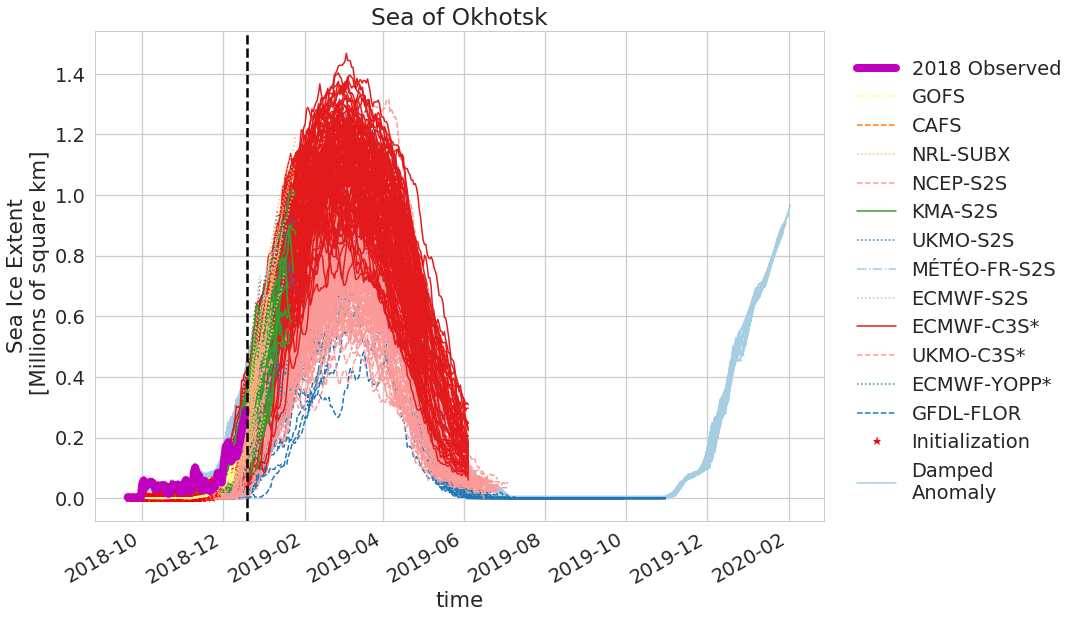

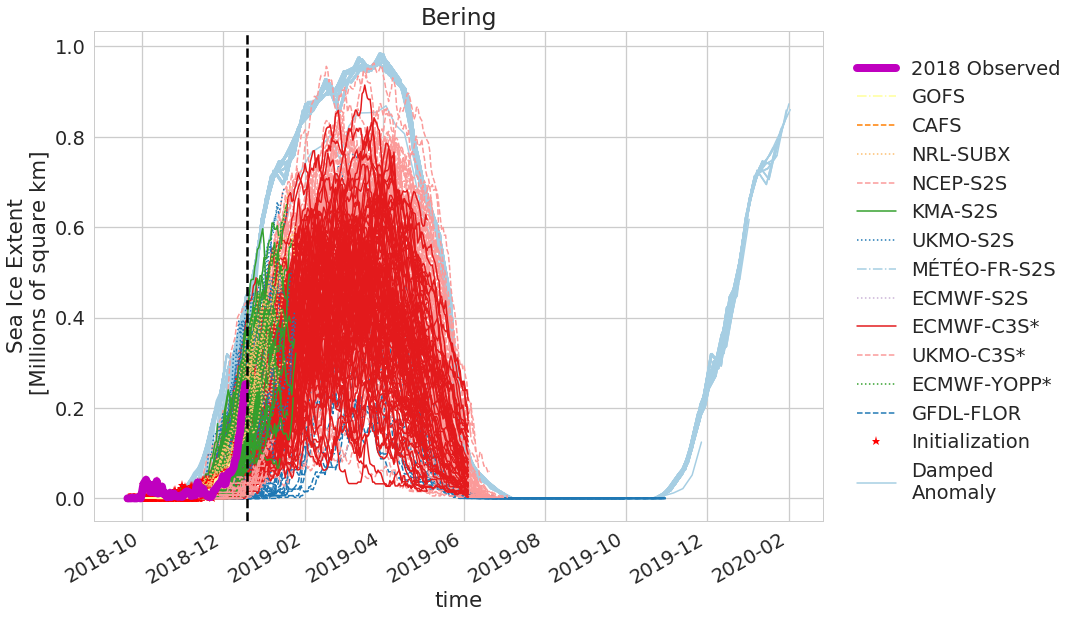

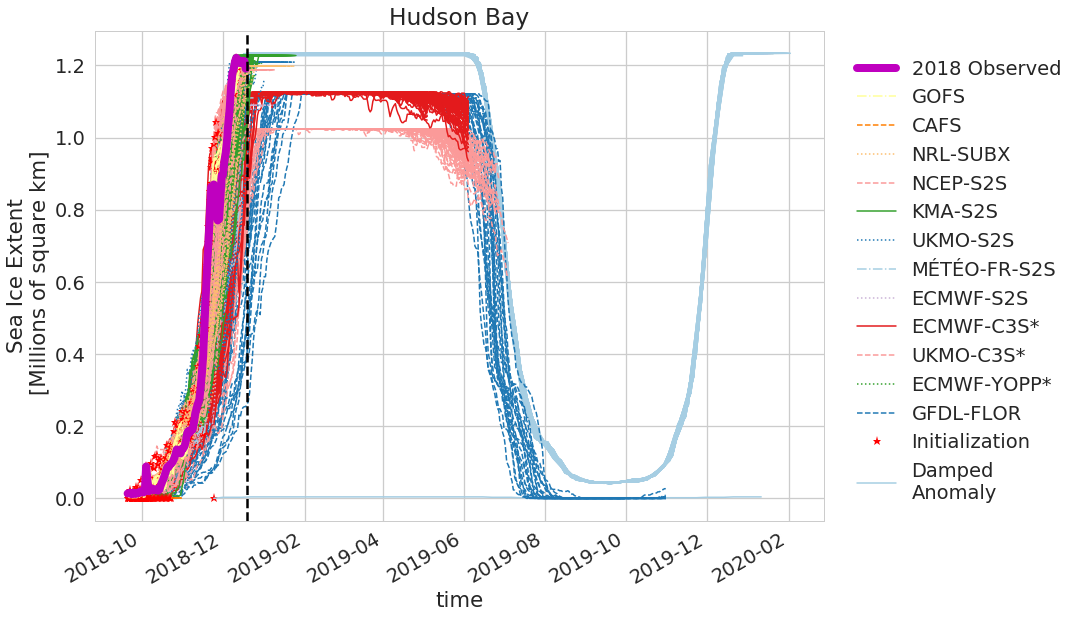

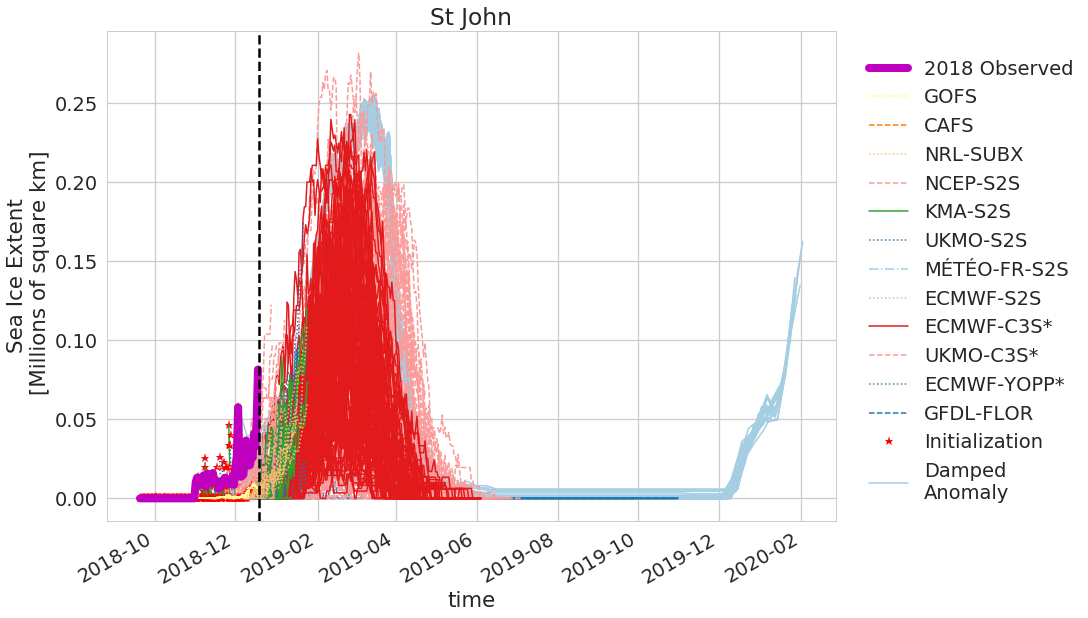

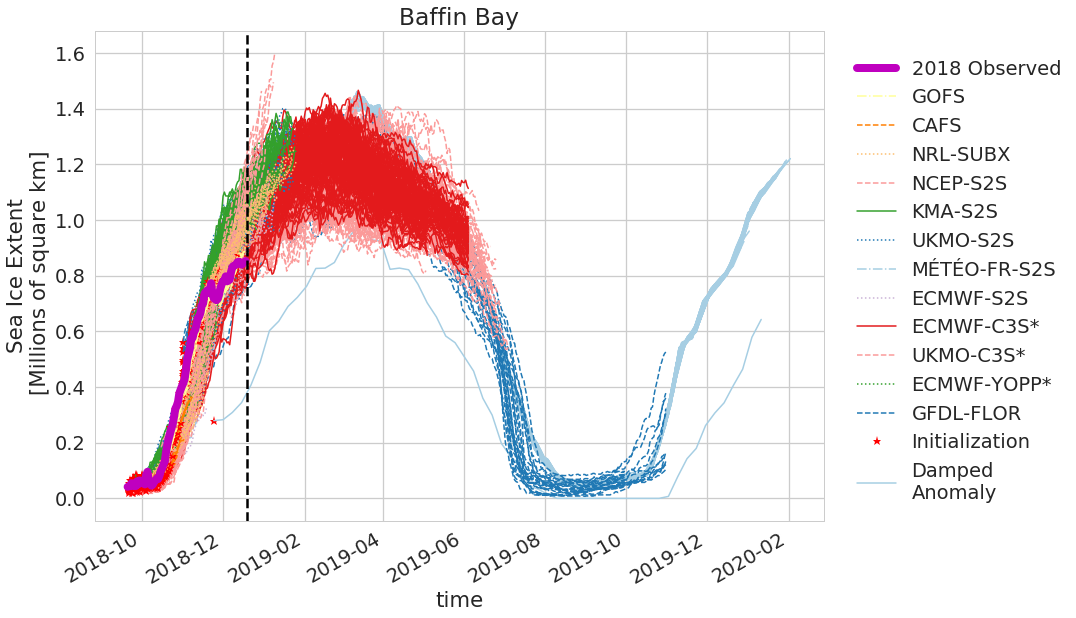

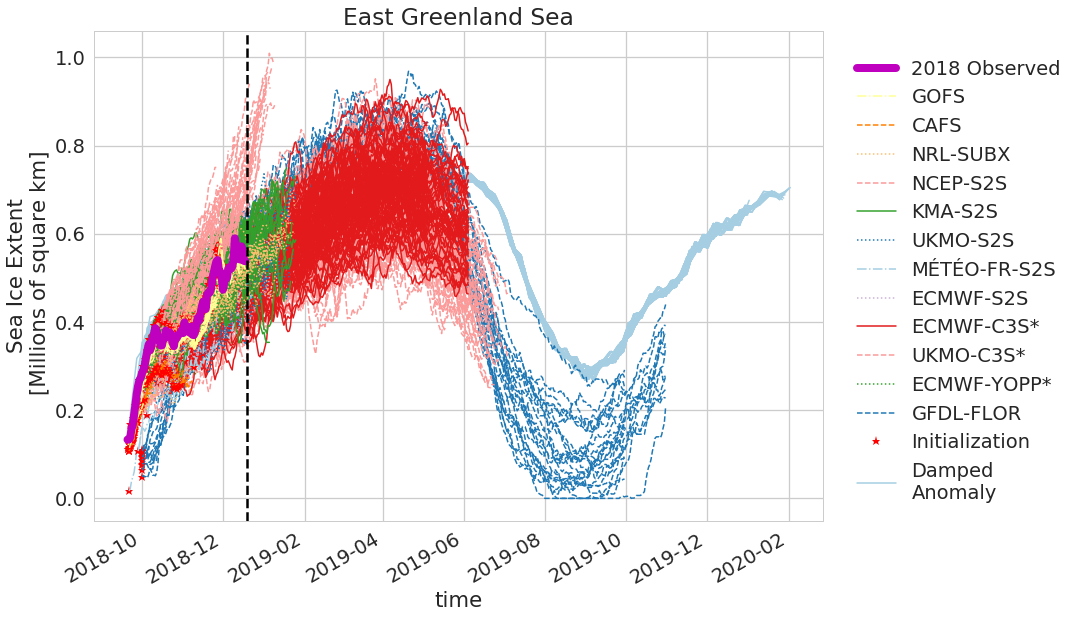

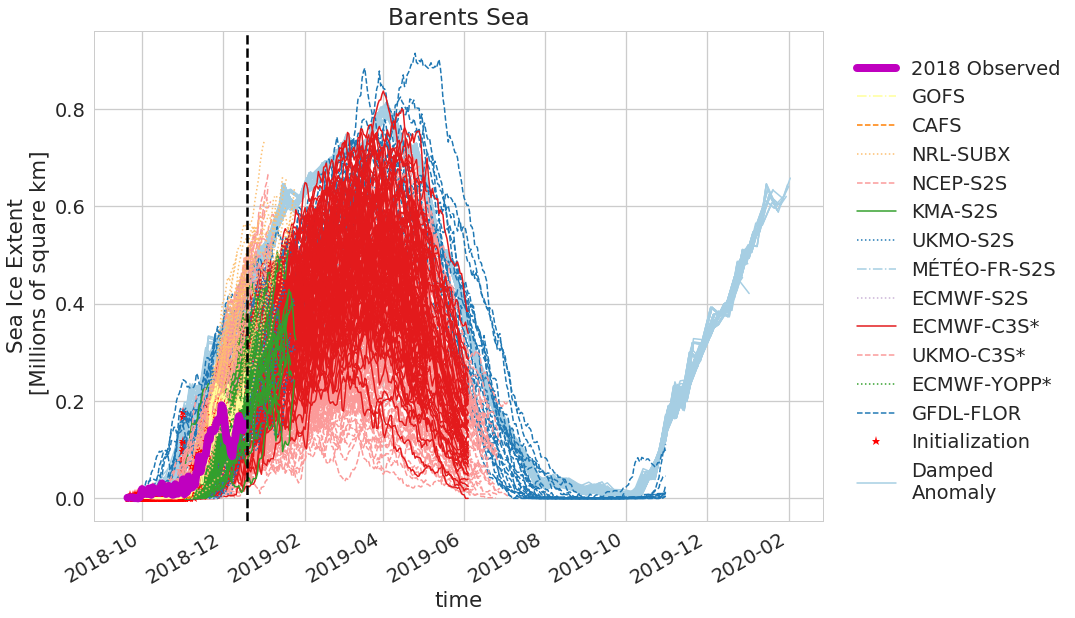

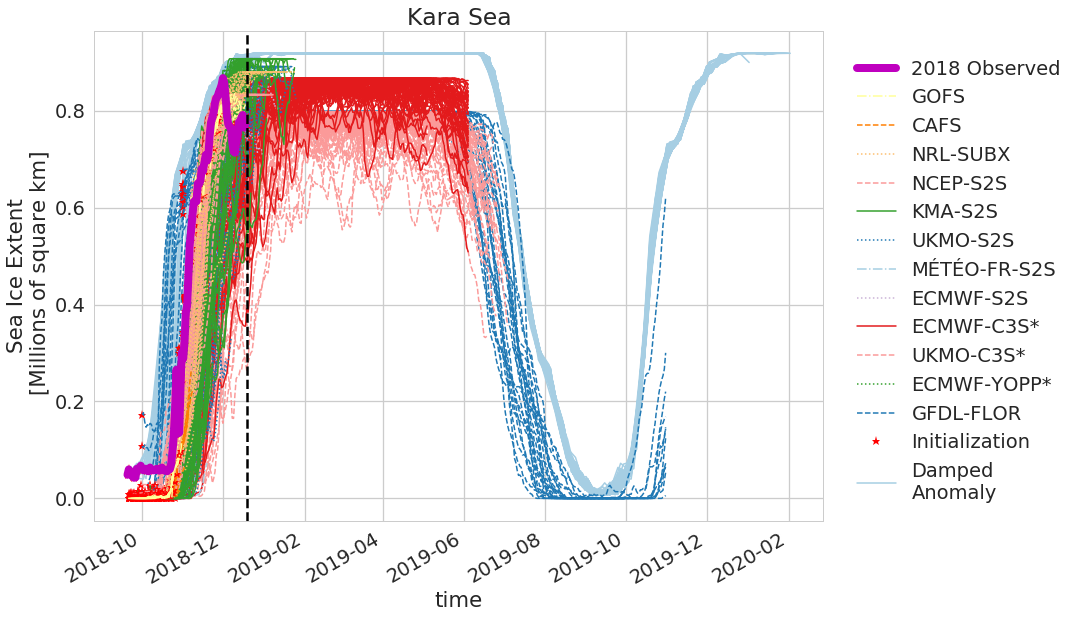

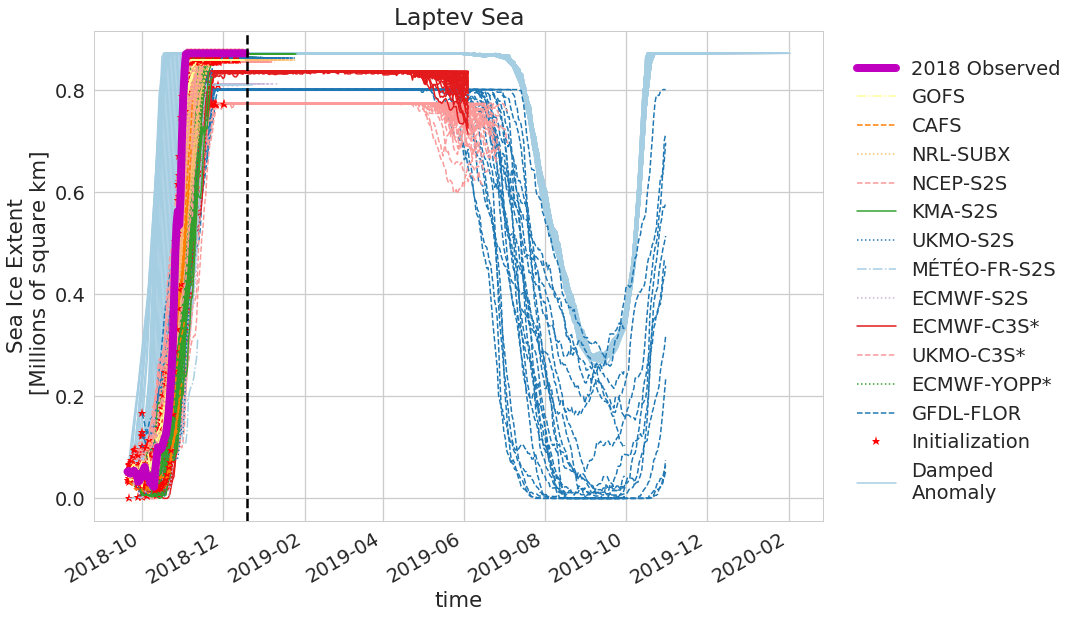

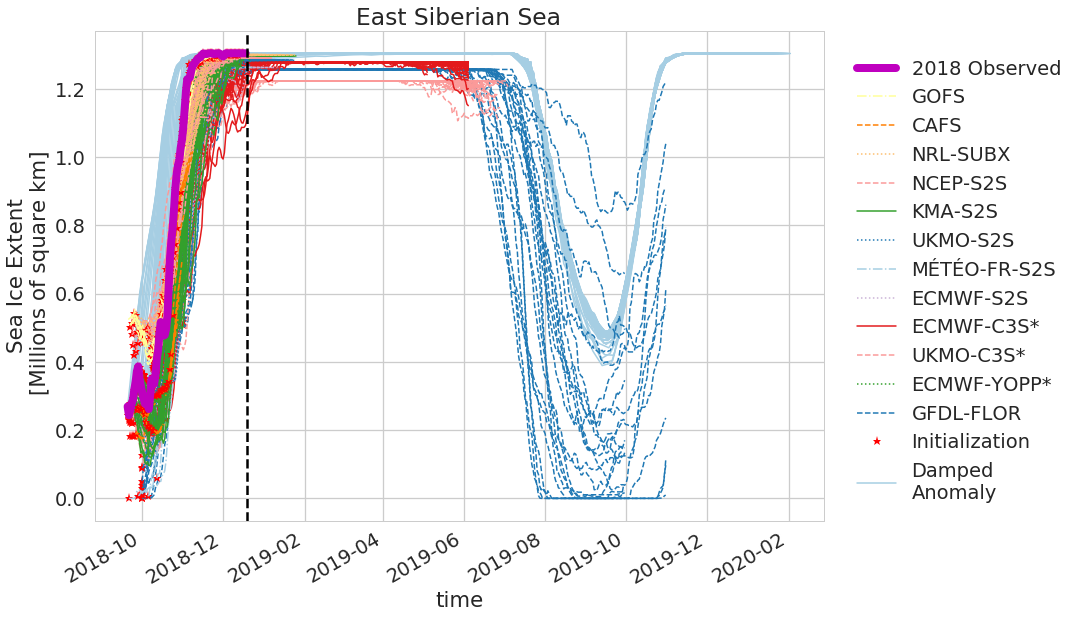

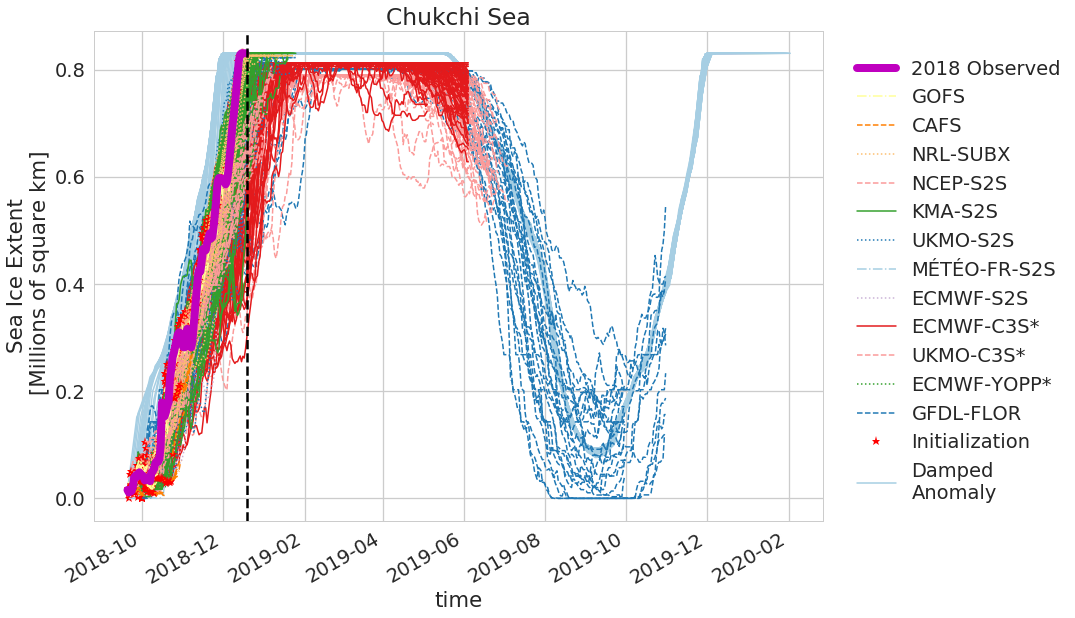

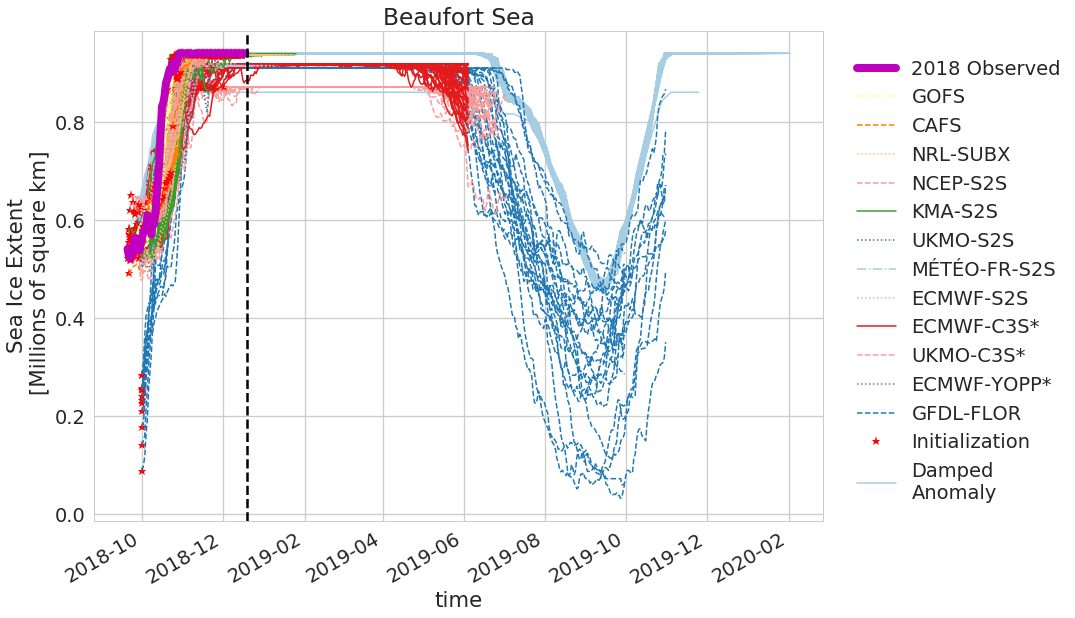

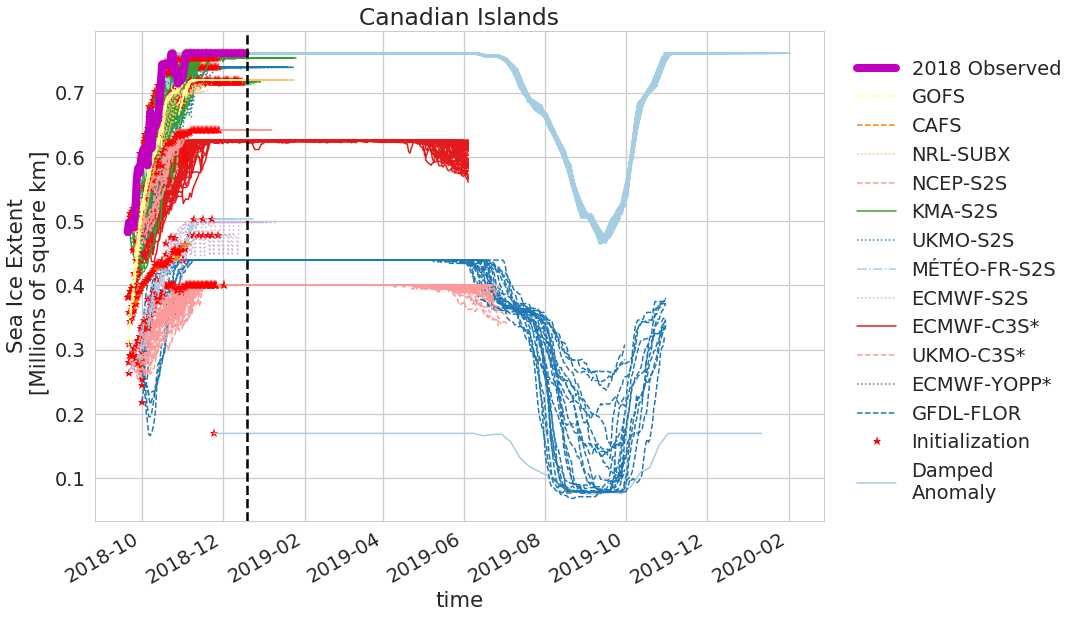

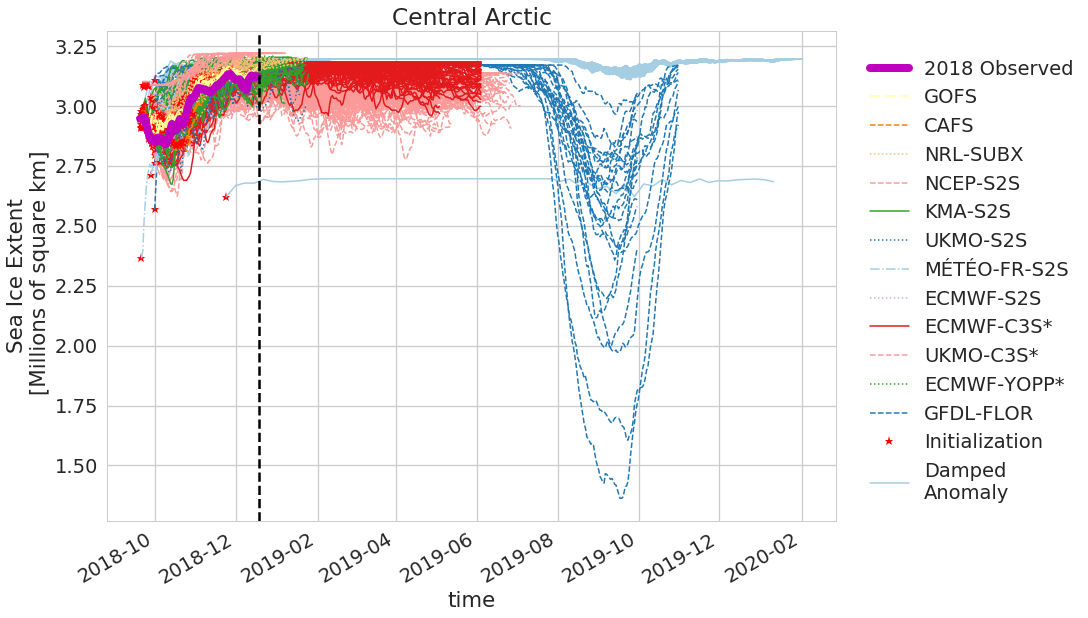

In [9]:
# cmap_c = itertools.cycle(sns.color_palette("Paired", len(E.model.keys()) ))
# linecycler = itertools.cycle(["-","--","-.",":","--"])
for cvar in variables:
    
    fig_dir = os.path.join(E.fig_dir, 'model', 'all_model', cvar, "regional_timeseries")
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    # For each region
    for cR in ds_region.ocean_regions.values:    
        cR_name = ds_region.region_names.sel(nregions=cR).item(0)
        print(cR_name)

        # New Plot
        f = plt.figure(figsize=(15,10))
        ax1 = plt.subplot(1, 1, 1) # Observations

        for (i, cmod) in enumerate(E.model.keys()):
#         for (i, cmod) in enumerate(['usnavyncep','usnavysipn']):

            if not E.icePredicted[cmod]:
                continue
            print(cmod)
            # Load in Model
            model_forecast = os.path.join(E.model[cmod][runType]['sipn_nc_agg'], '*.nc')

            # Check we have files 
            files = glob.glob(model_forecast)
            if not files:
                #print("Skipping model", cmod, "no forecast files found.")
                continue # Skip this model
            ds_model = xr.open_mfdataset(model_forecast, concat_dim='init_time')

            # Get Extent
            ds_model = ds_model.Extent

            # Select init of interest
            ds_model = ds_model.where(ds_model.init_time>=np.datetime64(SD), drop=True)
            
#             # Take mean of ensemble
#             ds_model = ds_model.mean(dim='ensemble')

            # Select region
            ds_model = ds_model.sel(nregions=cR)

            # Get model plotting specs
            cc = E.model_color[cmod]
            cl = E.model_linestyle[cmod]

            # Plot Model
            if i == 1: # Control only one initiailzation label in legend
                no_init_label = False
            else:
                no_init_label = True
            import timeit
            start_time = timeit.default_timer()
            
            ice_plot.plot_reforecast(ds=ds_model, axin=ax1, 
                                 labelin=E.model[cmod]['model_label'],
                                 color=cc, marker=None,
                                 linestyle=cl,
                                 no_init_label=no_init_label)
            print( (timeit.default_timer() - start_time), ' seconds.' )

            # Memeory clean up
            ds_model = None     
            
                

        # Plot observations
        print('Plotting observations')
        ds_obs_reg = ds_obs.sic.where(ds_obs.time>=np.datetime64(SD), drop=True)
        ds_obs_reg = ds_obs_reg.where(ds_region.mask==cR)
        ds_obs_reg = ((ds_obs_reg >= 0.15).astype('int') * ds_region.area).sum(dim='x').sum(dim='y')/(10**6)
        ds_obs_reg.plot(ax=ax1, label=str(cdate.year)+' Observed', color='m', linewidth=8)
        ax1.set_ylabel('Sea Ice Extent\n [Millions of square km]')
        cxlims = ax1.get_xlim()
        

    #     # 1980-2010 Historical Interquartile Range
    #     plt.fill_between(ds_per_mean.time.values, ds_per_mean + ds_per_std, 
    #                  ds_per_mean - ds_per_std, alpha=0.35, label='1980-2010\nInterquartile Range', color='m')
        ax1.set_xlim(cxlims) # fix x limits
        cylims = ax1.get_ylim()

        # Plot current date line
        ax1.plot([cd, cd], [cylims[0], cylims[1]], color='k', linestyle='--')
        
        ax1.set_title(cR_name)

        # Add legend (static)
        handles, labels = ax1.get_legend_handles_labels()
        ax1.legend(handles[::-1], labels[::-1], loc='lower right',bbox_to_anchor=(1.35, 0))

        f.autofmt_xdate()
        ax1.set_ylim(cylims)
        plt.subplots_adjust(right=.8)

        # Save to file
        base_name_out = 'Region_'+cR_name.replace(" ", "_")+'_'+metric1+'_'+runType+'_raw_predicted'
        f_out = os.path.join(fig_dir, base_name_out+'.png')
        f.savefig(f_out,bbox_inches='tight',dpi=200)
        mpld3.save_html(f, os.path.join(fig_dir, base_name_out+'.html'))

        # Mem clean up
        ds_model = None
        ds_obs_reg = None
        f = None